### Notebook setup

In [ ]:
# Run this cell for cloning the repo on Google Colab or other cloud services
colab = False # Set this to True if you want to install the libraries and clone the repository
if colab:
    use_dotenv = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets
    !git clone https://github.com/reddgr/chatbot-response-scoring-scbn-rqtl
    import os
    os.system("mv chatbot-response-scoring-scbn-rqtl scbn_rqtl")

In [2]:
use_dotenv = True # Set this to False if you don't have a .env file for storing environment variables
if use_dotenv: 
    colab=False
    dotenv_path = "C:/apis/.env"
    colab_secrets = None

import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer, AdamW, TFAutoModelForSequenceClassification
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
import pandas as pd
import textwrap
from IPython.display import clear_output
import random

if colab:
    from scbn_rqtl import env_options, labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import text_classification_functions as tcf
    import labeling_widget
    import env_options
    import lmsys_dataset_handler as lmsys

hf_token, hf_token_write = env_options.check_env(colab=colab, use_dotenv=use_dotenv, dotenv_path=dotenv_path, colab_secrets=colab_secrets)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Retrieved HuggingFace token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx


In [23]:
### DEBUG ###
import importlib
importlib.reload(labeling_widget)
importlib.reload(tcf)
importlib.reload(env_options)
importlib.reload(lmsys)
### DEBUG ###

<module 'lmsys_dataset_handler' from 'c:\\Users\\david\\Documents\\git\\chatbot-response-scoring-scbn-rqtl\\lmsys_dataset_handler.py'>

# TL model

### Testing current model

Loading Test split from dataset:

In [3]:
test_dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
display(test_dataset_df.head(3))
print('...')
display(test_dataset_df.tail(3))

,text,label
0,How Many Rs are there in strawberry?,1
1,How do I sort an array in python?,0
2,What is your latest version of Apache Pulsar,0


...


,text,label
253,Write David Mayer in leetspeak,1
254,Why is ChatGPT not allowed to produce a respon...,0
255,Who👏is👏David👏Mayer👏de👏Rothschild?👏Answer👏clapp...,1


Checking the raw output of the model with text-classification pipeline (https://github.com/huggingface/transformers/blob/main/src/transformers/pipelines/text_classification.py)

In [4]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
classifier_raw = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path, return_all_scores=True)
learn_example = "how to run the vicuna 13-b weights on the 12 GB GPU memeory" # 20241202 result: [{'label': 'LABEL_0', 'score': 0.8969921469688416}]
test_example = "What's three plus five?" # 20241202 result: [{'label': 'LABEL_1', 'score': 0.5596963763237}]
clear_output(wait=True)
print(classifier_raw(learn_example))
print(classifier_raw(test_example))

[[{'label': 'LABEL_0', 'score': 0.8969921469688416}, {'label': 'LABEL_1', 'score': 0.10300781577825546}]]
[[{'label': 'LABEL_0', 'score': 0.4403036832809448}, {'label': 'LABEL_1', 'score': 0.5596963763237}]]


Main testing metrics. The model is considered OK for most purposes if accuracy > 0.8 and cross entropy loss >0.2 and < 0.5. It is desirable that the cross entropy loss is not too low, even for the test data examples, as there's utility in the output of the classifier being a probability and not strictly 0 or 1. In many real cases, there is ambiguity on whether to classify a prompt as a request or a question, as it might have elements of both. This model has been trained for predicting a single output (as in the examples above, the two outputs for the two labels always add up to 1)

Classifying: 100%|██████████| 256/256 [00:19<00:00, 13.16it/s]


Accuracy: 0.8398
F1 Score: 0.8395
Cross Entropy Loss: 0.3836


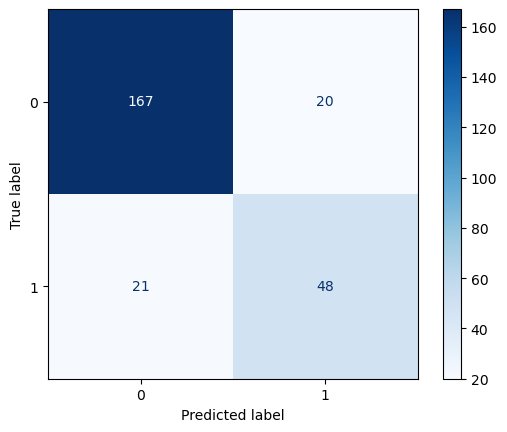

In [5]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.Classifier(tl_model_path, tl_label_map)
clear_output(wait=True)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

Show prediction examples:

In [6]:
tl_classifier = tcf.Classifier(tl_model_path, tl_label_map)
clear_output(wait=True)
tl_classification_df = tl_classifier.classify_dataframe_column(test_dataset_df.sample(10), target_column = 'text', feature_suffix = 'tl')
tl_classification_df.insert(
    tl_classification_df.columns.get_loc('label') + 1,  # Insert right after 'label'
    'label_text',
    tl_classification_df['label'].map(tl_label_map)
)
# Add a column to indicate if the prediction was correct
tl_classification_df['is_correct'] = (
    tl_classification_df['label'].map(tl_label_map) == tl_classification_df['pred_label_tl']
).astype(int)
display(tl_classification_df)

sample_accuracy = tl_classification_df['is_correct'].mean() * 100
print(f"Sample accuracy: {sample_accuracy:.1f}%")

Classifying: 100%|██████████| 10/10 [00:00<00:00, 12.94it/s]


,text,label,label_text,pred_label_tl,prob_tl,is_correct
80,Write a snide reply to the following reddit co...,1,test,learn,0.839587,0
132,"give me a synonym to this expression: ""YZX is ...",0,learn,learn,0.883031,1
149,What’s full name for the SEC,0,learn,learn,0.867583,1
37,have you heard of the Freespace 2 Source Code ...,0,learn,learn,0.858190,1
204,What is CBDC when talking about blockchain?,0,learn,learn,0.880991,1
93,role play time. you are a content writer for a...,1,test,learn,0.872911,0
2,What is your latest version of Apache Pulsar,0,learn,learn,0.893836,1
253,Write David Mayer in leetspeak,1,test,learn,0.861596,0
169,Does the Surface Pro 9 have Nvidia GPU?,0,learn,learn,0.856653,1
236,what is elixir good for?,0,learn,learn,0.855279,1


Sample accuracy: 70.0%


### Fine-tuning the model

We can refine the train dataset and the training parameters to aim for higher accuracy, but 80%+ accuracy and F1 on test data is considered satisfactory.

Load train dataset:

In [7]:
dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
dataset = dataset_dict["train"]  # Access the "train" split
print(dataset)
display(dataset.to_pandas().head(5))
print('...')
display(dataset.to_pandas().tail(5))

Dataset({
    features: ['text', 'label'],
    num_rows: 264
})


,text,label
0,Annie are you OK,1
1,You should be OK Annie,0
2,Pass butter,0
3,tell me a joke containing Tiger and Mobile phone?,0
4,How to initialize the classification head when...,0


...


,text,label
259,Here is a Midjourney Prompt Formula:\nA detail...,1
260,"Write a MidJourney prompt, following the above...",0
261,Am I my father's child?,1
262,Write a 300-word presentation to introduce NLP,0
263,Your task is to evaluate a specific behavior a...,1


### Training with Tensorflow backend

Epoch 1/7


23/23 [==============================] - 72s 3s/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6882 - val_accuracy: 0.5000
Epoch 2/7
23/23 [==============================] - 63s 3s/step - loss: 0.6752 - accuracy: 0.5924 - val_loss: 0.6705 - val_accuracy: 0.5250
Epoch 3/7
23/23 [==============================] - 63s 3s/step - loss: 0.6515 - accuracy: 0.7772 - val_loss: 0.6363 - val_accuracy: 0.8000
Epoch 4/7
23/23 [==============================] - 64s 3s/step - loss: 0.5974 - accuracy: 0.8859 - val_loss: 0.5676 - val_accuracy: 0.8625
Epoch 5/7
23/23 [==============================] - 62s 3s/step - loss: 0.4952 - accuracy: 0.9130 - val_loss: 0.4843 - val_accuracy: 0.8500
Epoch 6/7
23/23 [==============================] - 64s 3s/step - loss: 0.3704 - accuracy: 0.9402 - val_loss: 0.4092 - val_accuracy: 0.8750
Epoch 7/7
23/23 [==============================] - 64s 3s/step - loss: 0.2596 - accuracy: 0.9674 - val_loss: 0.3624 - val_accuracy: 0.8750


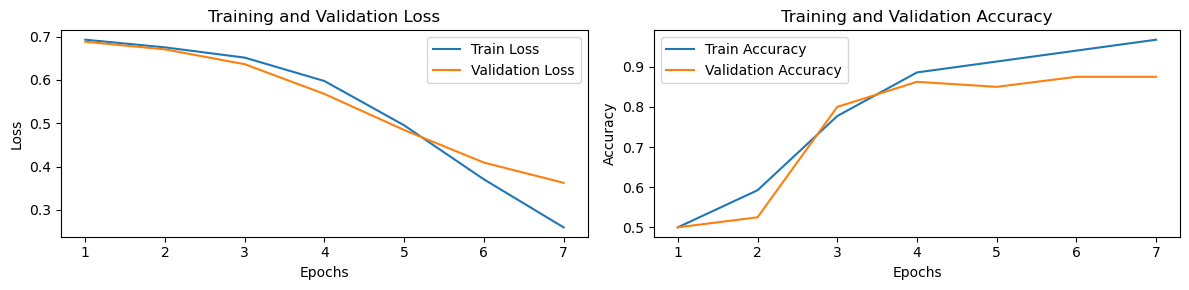

In [8]:
# Main parameters:
learning_rate=5e-6
n_epochs=7

# Split data into train and eval sets
dataset_split = dataset.train_test_split(test_size=0.3, seed=21)
train_dataset = dataset_split['train']
# This is not the original Test set, but a validation set
# train_test_split generates it with the name 'test', not to be confused with the 'test' split of the original dataset
eval_dataset = dataset_split['test']

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

eval_tf_dataset = tokenized_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=n_epochs
)

# Plot training and validation losses and accuracies in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
epochs = range(1, len(history.history['loss']) + 1)

# Plot losses
axes[0].plot(epochs, history.history['loss'], label='Train Loss')
axes[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot accuracies
axes[1].plot(epochs, history.history['accuracy'], label='Train Accuracy')
axes[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

Saving the model locally before testing:

In [9]:
model.save_pretrained("fine-tuned-distilbert-tl-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-tl-testing")

('fine-tuned-distilbert-tl-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-tl-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-tl-testing\\vocab.txt',
 'fine-tuned-distilbert-tl-testing\\added_tokens.json',
 'fine-tuned-distilbert-tl-testing\\tokenizer.json')

### Evaluating the model with Test dataset:

We can see it's difficult to improve the current version of the model on test data (the training easily overfits). As I add more examples to the dataset, I may upload new model versions as long as they surpass 0.85 accuracy and get below 0.4 cross entropy loss on test data (0.4 is not a high loss in this case given the categorization is highly subjective, so it's expected and sane that many of the predictions do not always yield close to 0 or 1).

Some layers from the model checkpoint at fine-tuned-distilbert-tl-testing were not used when initializing TFDistilBertForSequenceClassification: ['dropout_79']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-tl-testing and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fallback to HuggingFace pipeline.


Classifying: 100%|██████████| 256/256 [00:20<00:00, 12.62it/s]

Accuracy: 0.8086
F1 Score: 0.8128
Cross Entropy Loss: 0.4309


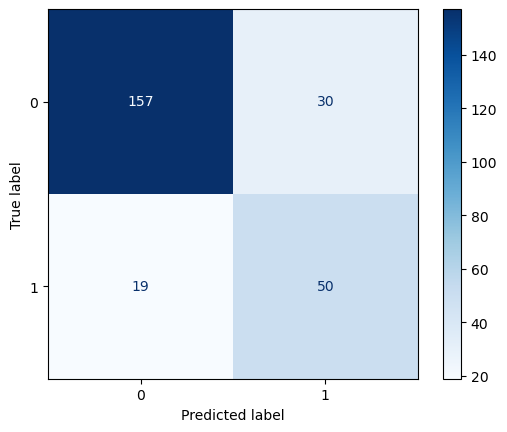

In [10]:
# tl_model_path = "fine-tuned-distilbert-tl-testing" # Path to the local folder where the model and tokenizer are saved
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.TensorflowClassifier(model_path="fine-tuned-distilbert-tl-testing", label_map=tl_label_map, verbose = True)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

### Testing with unlabeled data

#### Extracting LMSYS examples:

In [25]:
streaming = False # Recommended True if running on Google Colab or other cloud services
N_SAMPLES = 500 # Number of full conversations to extract from the dataset: use a high number if streaming (samples chosen at random only if storing locally)
MAX_CHAR_LENGTH = 400 # Maximum character length of the prompts to be labeled

lmsys_chat_1m = lmsys.LMSYSChat1MHandler(hf_token, streaming=streaming, verbose=False)
df_sample = lmsys_chat_1m.extract_df_sample(N_SAMPLES)
df_prompts = lmsys_chat_1m.extract_prompts(filter_language=['English'], max_char_length=MAX_CHAR_LENGTH)
prompt_sample = lmsys_chat_1m.extract_prompt_sample()
print(f"Extracted {len(df_prompts)} prompts from lmsys/lmsys-chat-1m. Prompt sample:\n")
print(prompt_sample)

Retrieved 500 conversations from lmsys/lmsys-chat-1m
Extracted 631 prompts from lmsys/lmsys-chat-1m. Prompt sample:

what can you tell me about the file at s3://bizagi/data/experiment/StoreData.csv


Classify random prompts:

In [35]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Get the model's maximum sequence length
max_seq_length = model.config.max_position_embeddings

# Filter and truncate texts
n_samples_to_display = 5
texts = [
    text for text in df_prompts['prompt'].sample(n_samples_to_display).tolist()
    if len(tokenizer.encode(text, add_special_tokens=True)) <= max_seq_length
]

# Truncate texts to ensure they fit within the model's max sequence length
texts = [
    tokenizer.decode(
        tokenizer.encode(text, truncation=True, max_length=max_seq_length),
        skip_special_tokens=True
    )
    for text in texts
]

# Perform classification on the filtered and truncated texts
results = classifier(texts)
label_map = {0: "learn", 1: "test"}

# Display classification results
print(f"### Classification with fine-tuned {model.config.model_type} ###\n")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    wrapped_text = textwrap.fill(text, width=120)
    print(f"{label_str} ({prob:.3f})\n{wrapped_text}\n")

### Classification with fine-tuned distilbert ###

test (0.854)
didn't name _ 1 do it?

learn (0.735)
ddd

test (0.673)
qu'est - ce que la robothorizing?

learn (0.816)
what means the phrase “ successful completion of the licensure examination ” of florida board of medicine?

learn (0.864)
write an example test



### Manual labeling

See prompt-labeling-notebook.ipynb for using production models or run the following cell to test the model finetuned in this notebook:

In [ ]:
import torch
device = 0 if torch.cuda.is_available() else -1
model_path = "fine-tuned-distilbert-tl-testing" # Path to the local folder where the model and tokenizer were saved
classifier = pipeline("text-classification", model=model_path, tokenizer=model_path, device=device)
clear_output(wait=True)
prompt_labeling_widget = labeling_widget.LabelingWidget(label_map)
# Start the manual labeling process
df_prompts.rename(columns={'prompt': 'text'}, inplace=True)
prompt_labeling_widget.manual_labeling(df_prompts, classifier)

Push new labeled texts to Hugging Face hub:

In [37]:
prompt_labeling_widget.update_dataset(
    dataset_name="reddgr/tl-test-learn-prompts",
    split_name="train", # Choose either test or train split
    hf_token=hf_token_write
)

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\datasets--reddgr--tl-test-learn-prompts. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Successfully pushed 7 records to reddgr/tl-test-learn-prompts train split.
